In [41]:
from qiskit import *
import numpy as np
import  math
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere, plot_histogram

Fermions are particles with odd half integer quantum spin (angular momentum) which obeys the Pauli's exclusion principle. 
For such a half spin particles, a rotation of 360 degrees (with respect to its environment) inverses the wave function of particle, in simple words it means a rotation of 360 degrees negates (puts a minus sign) in front of particle's state or its wave function(anti symmetric wavefunction), however a total of 720 degrees rotation (4 pi) for such particle take it back to its original state.

In the sample code below, we will see how a rotation of 2π takes a quantum state of a fermion only half way around the circle(π rotation) an introduces a global phase of e^π or -1, however it will take a rotation by 720 degrees to restore the global phase of 1 on the original quantum state.  

In [42]:
# Define a function which will return a gate equivalent to (control-Z)^n, this gate is used in a below circuit to change 
# the phase of control qubits by various powers of 2. 
def CU_Z(power) :
    circ = QuantumCircuit(2)
    circ.cz(0,1)
    Unitary = circ.to_gate()
    ret_unitary =  Unitary.power(power)
    return ret_unitary


In [43]:
# Define a function which will return a gate equivalent to (control-RZ(pi))^n, it is used in below circuit to change 
# the phase of control qubits by powers of 2, such that the control qubits carries the value of global phase introduced 
# by a single RZ(pi) in fourier (phase) basis.  
def CU_RZ(power) :
    circ = QuantumCircuit(2)
    circ.crz(np.pi, 0,1)
    Unitary = circ.to_gate()
    ret_unitary =  Unitary.power(power)
    return ret_unitary

In [44]:
# define a function that will convert the information from phase basis to computational basis 
def inv_qft(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1) # you don't need this step if you apply control Ops on qubits in reversed order 
    for j in range(n):
        for m in range(j):
            circuit.cp(-math.pi/float(2**(j-m)), m, j)
        circuit.h(j)

In [45]:
# Run a circuit to calculate global phase introduced by a Rz(pi) gate
nqubits = 3
qc = QuantumCircuit(nqubits + 1, nqubits)
qc.h(range(nqubits))  # set control qubits to phase basis
qc.x(nqubits)  # comment this line to choose |0> eigen vector, it will not change the results

qc.append(CU_RZ(1), [0, nqubits])  # Kickback a phase introduced by Rz(pi) times 2^0 to 0th control qubit
qc.append(CU_RZ(2), [1, nqubits])  # Kickback the phase introduced by Rz(pi) times 2^1 to 1st control qubit
qc.append(CU_RZ(4), [2, nqubits])  # Kickback the phase introduced by Rz(pi) times 2^2 to 2nd control qubit
qc.draw()


┌───┐┌───────────────┐                                  
q_0: ┤ H ├┤0              ├──────────────────────────────────
     ├───┤│               │┌───────────────┐                 
q_1: ┤ H ├┤               ├┤0              ├─────────────────
     ├───┤│  circuit167^1 ││               │┌───────────────┐
q_2: ┤ H ├┤               ├┤  circuit170^2 ├┤0              ├
     ├───┤│               ││               ││  circuit173^4 │
q_3: ┤ X ├┤1              ├┤1              ├┤1              ├
     └───┘└───────────────┘└───────────────┘└───────────────┘
c: 3/════════════════════════════════════════════════════════

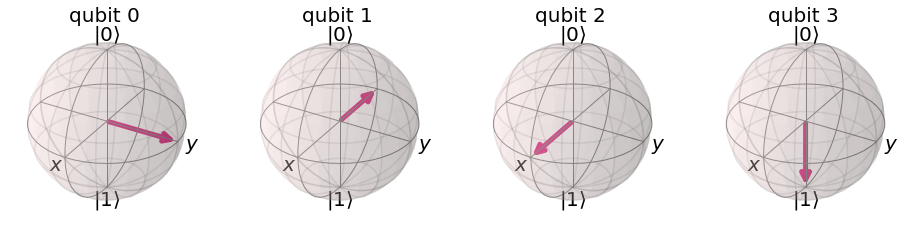

In [46]:
# print qubits on Bloch sphere to witness the global phase introduced by a Rz(pi) rotation 
bkend = Aer.get_backend('statevector_simulator')
job = execute(qc, bkend)
sv1 = job.result().get_statevector(qc)
#print(sv1)
plot_bloch_multivector(sv1)

In [47]:
# apply inverse qft to read convert infomration coded in phase basis to computational basis
inv_qft(qc, nqubits)
qc.measure(range(nqubits), range(nqubits))
qc.draw()

┌───┐┌───────────────┐                                     ┌───┐»
q_0: ┤ H ├┤0              ├───────────────────────────────────X─┤ H ├»
     ├───┤│               │┌───────────────┐                  │ └───┘»
q_1: ┤ H ├┤               ├┤0              ├──────────────────┼──────»
     ├───┤│  circuit167^1 ││               │┌───────────────┐ │      »
q_2: ┤ H ├┤               ├┤  circuit170^2 ├┤0              ├─X──────»
     ├───┤│               ││               ││  circuit173^4 │        »
q_3: ┤ X ├┤1              ├┤1              ├┤1              ├────────»
     └───┘└───────────────┘└───────────────┘└───────────────┘        »
c: 3/════════════════════════════════════════════════════════════════»
                                                                     »
«                                           ┌─┐           
«q_0: ─────■───────────────■────────────────┤M├───────────
«     ┌────┴────┐┌───┐     │                └╥┘     ┌─┐   
«q_1: ┤ P(-π/2) ├┤ H ├─────┼──────────■──────╫──────┤M├───
«     └─────────┘└───┘┌────┴────┐┌────┴────┐ ║ ┌───┐└╥┘┌─┐
«q_2: ────────────────┤ P(-π/4) ├┤ P(-π/2) ├─╫─┤ H ├─╫─┤M├
«                     └─────────┘└─────────┘ ║ └───┘ ║ └╥┘
«q_3: ───────────────────────────────────────╫───────╫──╫─
«                                            ║       ║  ║ 
«c: 3/═══════════════════════════════════════╩═══════╩══╩═
«                                            0       1  2

{'010': 100}
Global Phase introduced by Rz(pi) gate is =  1.5707963267948966  radians and  90.0  Degrees.


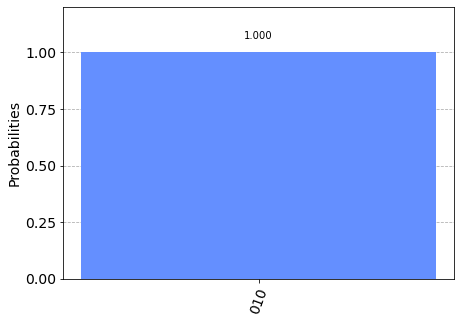

In [48]:
# Run circuit with qasm simulator or real quantum computer on cloud to obtain the value of global phase using IQFT
# We only have to measure first three qubits from LSB as the state on MSB qubit will remain unchanged  
bkend = Aer.get_backend('qasm_simulator')
job = execute(qc, bkend, shots=100)
cnt1 = job.result().get_counts(qc)
print(cnt1)
max_val = max(cnt1, key=cnt1.get)
max_val_dec = int(max_val, 2)
print('Global Phase introduced by Rz(pi) gate is = ', (2*np.pi)/(2**nqubits) * max_val_dec, ' radians and ', (360/(2**nqubits) * max_val_dec), ' Degrees.')
plot_histogram(cnt1)


In [49]:
#### Lets run same routine with Z gate that rotate the state vector on bloch sphere by pi radians around Z axis 

In [50]:
# Run below circuit to calculate the global phase introduced by Z gate
nqubits = 3
qc_z = QuantumCircuit(nqubits + 1, nqubits)
qc_z.h(range(nqubits))
qc_z.x(nqubits)

qc_z.append(CU_Z(1), [0, nqubits])  #Kickback the phase introduced by a Z gate times 2^0 to 0th control qubit
qc_z.append(CU_Z(2), [1, nqubits])  #Kickback a phase introduced by a Z gate times 2^1 to 0th control qubit
qc_z.append(CU_Z(4), [2, nqubits])  #Kickback a phase introduced by a Z gate times 2^2 to 0th control qubit

qc_z.draw()


┌───┐┌───────────────┐                                  
q_0: ┤ H ├┤0              ├──────────────────────────────────
     ├───┤│               │┌───────────────┐                 
q_1: ┤ H ├┤               ├┤0              ├─────────────────
     ├───┤│  circuit179^1 ││               │┌───────────────┐
q_2: ┤ H ├┤               ├┤  circuit182^2 ├┤0              ├
     ├───┤│               ││               ││  circuit185^4 │
q_3: ┤ X ├┤1              ├┤1              ├┤1              ├
     └───┘└───────────────┘└───────────────┘└───────────────┘
c: 3/════════════════════════════════════════════════════════

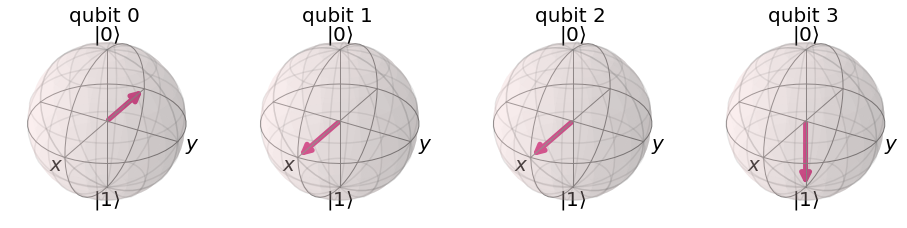

In [51]:
# print qubits on Bloch Sphere to get the global phase introduced by a Z gate 
bkend = Aer.get_backend('statevector_simulator')
job = execute(qc_z, bkend)
sv2 = job.result().get_statevector(qc_z)
#print(sv2)
plot_bloch_multivector(sv2)

In [52]:
# apply inverse qft to read convert information coded in phase basis to computational basis
inv_qft(qc_z, nqubits)
qc_z.measure(range(nqubits), range(nqubits))
qc_z.draw()

┌───┐┌───────────────┐                                     ┌───┐»
q_0: ┤ H ├┤0              ├───────────────────────────────────X─┤ H ├»
     ├───┤│               │┌───────────────┐                  │ └───┘»
q_1: ┤ H ├┤               ├┤0              ├──────────────────┼──────»
     ├───┤│  circuit179^1 ││               │┌───────────────┐ │      »
q_2: ┤ H ├┤               ├┤  circuit182^2 ├┤0              ├─X──────»
     ├───┤│               ││               ││  circuit185^4 │        »
q_3: ┤ X ├┤1              ├┤1              ├┤1              ├────────»
     └───┘└───────────────┘└───────────────┘└───────────────┘        »
c: 3/════════════════════════════════════════════════════════════════»
                                                                     »
«                                           ┌─┐           
«q_0: ─────■───────────────■────────────────┤M├───────────
«     ┌────┴────┐┌───┐     │                └╥┘     ┌─┐   
«q_1: ┤ P(-π/2) ├┤ H ├─────┼──────────■──────╫──────┤M├───
«     └─────────┘└───┘┌────┴────┐┌────┴────┐ ║ ┌───┐└╥┘┌─┐
«q_2: ────────────────┤ P(-π/4) ├┤ P(-π/2) ├─╫─┤ H ├─╫─┤M├
«                     └─────────┘└─────────┘ ║ └───┘ ║ └╥┘
«q_3: ───────────────────────────────────────╫───────╫──╫─
«                                            ║       ║  ║ 
«c: 3/═══════════════════════════════════════╩═══════╩══╩═
«                                            0       1  2

{'100': 100}
Global Phase introduced by a Z gate is =  3.141592653589793  radians and  180.0  Degrees.


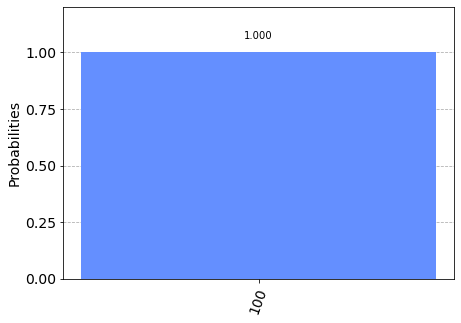

In [53]:
# Run circuit with qasm simulator or real quantum computer on cloud to extract and print the value of global phase 
# using IQFT introduced by a Z gate, We only have to measure the first three qubits from LSB as the state on MSB qubit 
# will remain unchanged
bkend = Aer.get_backend('qasm_simulator')
job = execute(qc_z, bkend, shots=100)
cnt2 = job.result().get_counts(qc_z)
print(cnt2)
max_val = max(cnt2, key=cnt2.get)
max_val_dec = int(max_val, 2)
print('Global Phase introduced by a Z gate is = ', (2*np.pi)/(2**nqubits) * max_val_dec, ' radians and ', (360/(2**nqubits) * max_val_dec), ' Degrees.')
plot_histogram(cnt2)

In [54]:
# end of program